In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from matplotlib import pyplot
import os
import random
from tensorflow import keras
from tensorflow.python.ops.rnn import static_rnn
from tensorflow.python.ops.rnn_cell_impl import BasicLSTMCell
 
vocab_size=10000 # vocabulary size
max_seq_num = 256 # maximum sentence length
num_dimensions = 50 # vocabulary vector length
batch_size = 64 # batch size
num_labels = 2  # labels number
iterations = 1000 # iterations number
dropout_keep_prob = 0.5  # dropout keep probability
learning_rate = 1e-3
 
 

Instructions for updating:
non-resource variables are not supported in the long term


Training data: 
(50000,)
(50000,)
Classes: 
[0 1]
imdb data lens:218,189
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 

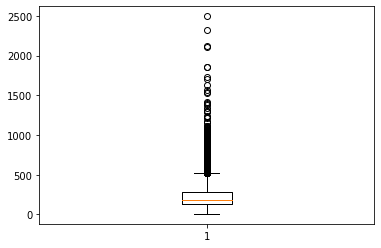

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    1   14   22   16
   43  530  973 1622 1385   65  458 4468   66 3941    4  173   36  256
    5   25  100   43  838  112   50  670    2    9   35  480  284    5
  150    4  172  112  167    2  336  385   39    4  172 4536 1111   17
  546   38   13  447    4  192   50   16    6  147 2025   19   14   22
    4 1920 4613  469    4   22   71   87   12   16   43  530   38   76
   15   13 1247    4   22   17  515   17   12   16  626   18    2    5
   62  386   12    8  316    8  106    5    4 2223 5244   16  480   66
 3785   33    4  130   12   16   38  619    5   25  124   51   36  135
   48   25 1415   33    6   22   12  215   28   77   52    5   14  407
   16   82    2    8    4  107  117 5952   15  256    4    2    7 3766
    5  723   36   71   43  530  476   26  400  317   46    7    4    2
 1029 

In [4]:
#1. download imdb data and show data examples
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)
X = np.concatenate((train_data, test_data), axis=0)
y = np.concatenate((train_labels,test_labels), axis=0)

# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

# Summarize number of classes
print("Classes: ")
print(np.unique(y))
print('imdb data lens:%d,%d'%(len(train_data[0]), len(train_data[1])))
print(train_data[0])
print(train_labels[0])

# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

# Summarize review length
print("Review length: ")
result = [len(X) for X in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()
 
# Expand the integer array, and add 0 after the sequence
train_data = keras.preprocessing.sequence.pad_sequences(train_data,maxlen=max_seq_num) 
test_data = keras.preprocessing.sequence.pad_sequences(test_data,maxlen=max_seq_num)
print(train_data[0])

In [5]:
 
#2. setup model


tf.reset_default_graph()
X_holder = tf.placeholder(tf.int32, [None, max_seq_num])
Y_holder = tf.placeholder(tf.int32, [None])
embedding = tf.get_variable('embedding', [vocab_size, num_dimensions])
embedding_inputs = tf.nn.embedding_lookup(embedding, X_holder)
 
# lstm
# 0.Original input data format: batch_size,max_seq_num,num_dimensions
# 1.To merge data, rnn_input is an array of max_seq_num length, and the array elements are tensor
rnn_input = tf.unstack(embedding_inputs, max_seq_num, axis=1)
print("rnn_input shape:%s,%s"%(len(rnn_input),rnn_input[0].shape))
lstm_cell = BasicLSTMCell(20, forget_bias=1.0)
lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=dropout_keep_prob)
rnn_outputs, rnn_states = static_rnn(lstm_cell, rnn_input, dtype=tf.float32)

# nn_outputs is an array of max_seq_num length, the array elements are (batch_size, 20) tensor
print("rnn_outputs shape:%s,%s"%(len(rnn_outputs),rnn_outputs[0].shape))

# rnn_states is a 2-length array whose elements are (batch_size, 20) tensors
print("rnn_states shape:%s,%s"%(len(rnn_states),rnn_states[0].shape))
logits = tf.layers.dense(rnn_outputs[-1], num_labels)
predict_Y = tf.argmax(logits, axis=1)
losses = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(Y_holder, num_labels),
    logits = logits
)
 
mean_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(mean_loss)
isCorrect = tf.equal(Y_holder, tf.cast(predict_Y, dtype=tf.int32))
accuracy = tf.reduce_mean(tf.cast(isCorrect, tf.float32))

rnn_input shape:256,(?, 50)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
rnn_outputs shape:256,(?, 20)
rnn_states shape:2,(?, 20)
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [7]:
 
# training
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)
 
steps = np.zeros(iterations)
ACCURACY = np.zeros_like(steps)
MEAN_LOSS = np.zeros_like(steps)
 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print ("begin training")
    # training
    for step in range(iterations):
        #selected_index = random.sample(list(range(len(train_data))), k=batch_size)
        selected_index = np.random.choice(len(train_data),size=batch_size)
        batch_X = train_data[selected_index]
        batch_Y = train_labels[selected_index]
        feed_dict = {
            X_holder: batch_X,
            Y_holder: batch_Y
        }
        _, mean_loss_val,accuracy_value = sess.run([optimizer, mean_loss,accuracy], feed_dict=feed_dict)
        steps[step]=step
        ACC[step]=accuracy_value
        MEAN_LOSS[step]=mean_loss_val
        
        print("rnn_outputs shape:%s,%s"%(len(rnn_outputs),rnn_outputs[0].shape))
        if step%10 == 0:
            print ("step = {}\t mean loss ={} accuracy ={}".format(step, mean_loss_val,accuracy_value))

begin training
rnn_outputs shape:256,(?, 20)
step = 0	 mean loss =0.6921213865280151 accuracy =0.59375
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
step = 10	 mean loss =0.6892127990722656 accuracy =0.65625
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
step = 20	 mean loss =0.6913875341415405 accuracy =0.53125
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)
rnn_outputs shape:256,(?, 20)

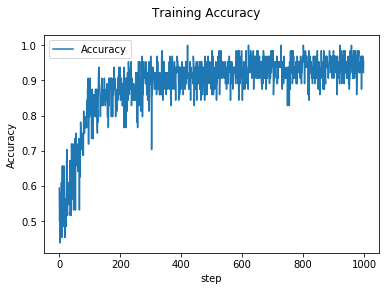

In [8]:

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(steps,ACC,label='Accuracy')
ax.set_xlabel('step')
ax.set_ylabel('Accuracy')
fig.suptitle('Training Accuracy')
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles,labels=labels)
plt.show()


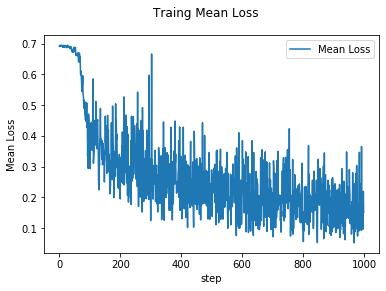

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(steps,MEAN_LOSS,label='Mean Loss')
ax.set_xlabel('step')
ax.set_ylabel('Mean Loss')
fig.suptitle('Traing Mean Loss')
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles,labels=labels)
plt.show()